<a href="https://colab.research.google.com/github/aliciachenw/11785-project/blob/main/project_fine_tuning_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount drive and install**

In [ ]:
# load google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 7.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=0e1089eed4d229d5cb5d86f0aedb8a4dbd25170008996fc5e3c4d0adddbce761
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 26kB/s 
     |████████████████████████████████| 5.9MB 24.2MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C)

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 680kB/s 
     |████████████████████████████████| 2.2MB 8.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201104-cp36-none-any.whl size=44419 sha256=e8abea993dc3918611b204d2d5fbafa9fba9ec42634386e4e9f7d1c2223770cb
  Stored in directory: /root/.cache/pip/wheels/ec/4d/40/4077356fe02ef345791713eabede5ed63afe7d613b016694d1
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


# **Basic setup**

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# **Run on custom dataset**

**Train-validation split**

split the training dataset into validation and training

In [ ]:
def split_train_vld(img_dir, split=None):
  json_file = os.path.join(img_dir, "thermal_annotations.json")
  with open(json_file) as f:
    json_data = json.load(f)
    imgs_info = json_data["info"]
    imgs_categories = json_data["categories"]
    imgs_license = json_data["licenses"]
    imgs_anns = json_data["annotations"]
    imgs_infos = json_data["images"]
  
  dataset_dicts = []
  pointer = 0

  for idx, v in enumerate(imgs_infos):
    record = {}
    record["image_id"] = idx
    record["images"] = v
    objs = []
    while pointer < len(imgs_anns):
      annotation = imgs_anns[pointer]
      if annotation["image_id"] == record["image_id"]:
        if annotation["category_id"] == 1:
          obj = annotation
          objs.append(obj)
        pointer += 1
      else:
        record["annotations"] = objs
        dataset_dicts.append(record)
        break
  if split != None:
    length_data = len(dataset_dicts)
    random_train = int(split * length_data)
    random.shuffle(dataset_dicts)
    train_dicts = dataset_dicts[:random_train]
    vld_dicts = dataset_dicts[random_train:]

    with open(img_dir + '/train.json', 'w') as fp:
      training_images = []
      training_annotations = []
      for instance in train_dicts:
        training_images.append(instance["images"])
        training_annotations = training_annotations + instance["annotations"]

      training_dicts = {}
      training_dicts["info"] = imgs_info
      training_dicts["categories"] = imgs_categories
      training_dicts["license"] = imgs_license
      training_dicts["annotations"] = training_annotations
      training_dicts["images"] = training_images
      json.dump(training_dicts, fp, indent=4)

    with open(img_dir + '/vld.json', 'w') as fp:
      validation_images = []
      validation_annotations = []
      for instance in vld_dicts:
        validation_images.append(instance["images"])
        validation_annotations = validation_annotations + instance["annotations"]

      validation_dicts = {}
      validation_dicts["info"] = imgs_info
      validation_dicts["categories"] = imgs_categories
      validation_dicts["license"] = imgs_license
      validation_dicts["annotations"] = validation_annotations
      validation_dicts["images"] = validation_images
      json.dump(validation_dicts, fp, indent=4)
    # return train_dicts, vld_dicts

In [ ]:
 split_train_vld(dataset_dir + "/train", 0.7)

**Custom dataset loader**

Convert the dataset to default coco format

In [ ]:
from detectron2.structures import BoxMode

def get_thermal_dict(img_dir, set_type):
  if set_type == "train":
    json_file = os.path.join(img_dir, "train/train.json")
  elif set_type == "vld":
    json_file = os.path.join(img_dir, "train/vld.json")
  else:
    json_file = os.path.join(img_dir, "val/thermal_annotations.json")
  with open(json_file) as f:
    json_data = json.load(f)
    imgs_anns = json_data["annotations"]
    imgs_infos = json_data["images"]
  
  dataset_dicts = []
  pointer = 0

  for idx, v in enumerate(imgs_infos):
    record = {}

    record["image_id"] = v["id"]
    if set_type == "train" or set_type == "vld":
      record["file_name"] = os.path.join(img_dir, "train", v["file_name"])
    else:
      record["file_name"] = os.path.join(img_dir, "val", v["file_name"])
    record["height"] = v["height"]
    record["width"] = v["width"]
    # print("load images")
    # print(record["image_id"])
    # print("load annotation")
    # print(idx)

    objs = []

    while pointer < len(imgs_anns):
      annotation = imgs_anns[pointer]
      # print(annotation["image_id"])
      if annotation["image_id"] == record["image_id"]:
        if annotation["category_id"] == 1:
          
          obj = {
              "bbox": annotation["bbox"],
              "bbox_mode": BoxMode.XYWH_ABS, 
              "segmentation": annotation["segmentation"],
              "category_id": 0
          }
          objs.append(obj)
        pointer += 1
      else:
        record["annotations"] = objs
        dataset_dicts.append(record)
        break

  return dataset_dicts


Register training, validation and test dataset

In [ ]:
dataset_dir = "/content/gdrive/My Drive/FLIR/"

for d in ["train", "vld", "test"]:
  DatasetCatalog.register("FLIR_" + d, lambda d=d: get_thermal_dict(dataset_dir, d))
  MetadataCatalog.get("FLIR_" + d).set(thing_classes=["person"])
FLIR_metadata = MetadataCatalog.get(dataset_dir)

Visualization of dataset loading

/content/gdrive/My Drive/FLIR/train/thermal_8_bit/FLIR_05082.jpeg


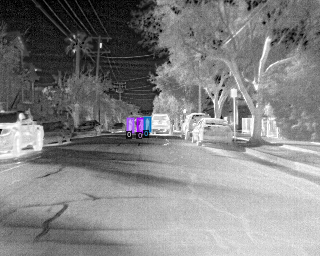

/content/gdrive/My Drive/FLIR/train/thermal_8_bit/FLIR_00552.jpeg


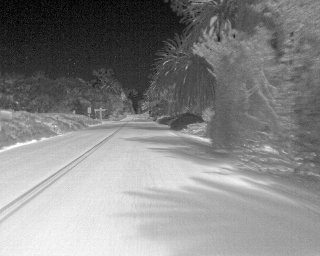

/content/gdrive/My Drive/FLIR/train/thermal_8_bit/FLIR_03091.jpeg


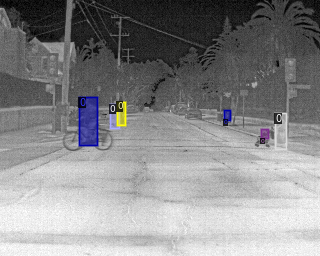

In [ ]:
import cv2

dataset_dicts = get_thermal_dict(dataset_dir, "train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=FLIR_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# **Load exist model and evaluator**

**Build configuration and load pretrain model**

Pretrain model: mask rcnn on COCO

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("FLIR_train",)
cfg.DATASETS.TEST = ("FLIR_vld")
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 16
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/08 19:13:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

**Build custom evaluator**

In [ ]:
from detectron2.evaluation import DatasetEvaluator
from detectron2.structures import Boxes, BoxMode, pairwise_iou
import torch
from detectron2.data import build_detection_test_loader
import numpy as np


class CustomEvaluator(DatasetEvaluator):
  def reset(self):
    self.iou = []
    self.tp = 0
    self.fp = 0
    self.tn = 0
    self.fn = 0
    self.num_labels = 0
    self.num_instances = 0

  def process(self, inputs, annotations, outputs, iou_threshold):
    anno = annotations[0]["annotations"]
    # print(outputs)
    pred_boxes = outputs[0]["instances"].pred_boxes.to('cpu')
    gt_boxes = [BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS) for obj in anno]
    gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
    gt_boxes = Boxes(gt_boxes)
    gt_overlaps = []

    self.num_labels += len(gt_boxes)
    self.num_instances += len(pred_boxes)

    if len(gt_boxes) != 0 and len(pred_boxes) != 0:
      
      overlaps = pairwise_iou(pred_boxes, gt_boxes)
      
      _gt_overlaps = torch.zeros(len(gt_boxes))

      for j in range(min(len(pred_boxes), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)

          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0
          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]
          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]
          assert _gt_overlaps[j] == gt_ovr
          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1

          if gt_ovr < iou_threshold:
            self.fp += 1
          else:
            self.tp += 1
  
          # append recorded iou coverage level
          gt_overlaps.append(_gt_overlaps)
      gt_overlaps = (torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32))
      gt_overlaps, _ = torch.sort(gt_overlaps)
      gt_overlaps = gt_overlaps.detach().numpy() 
      self.iou.append(list(gt_overlaps))

  def evaluate(self):
    # save self.count somewhere, or print it, or return it.
    true_positive = self.tp
    false_positive = self.num_instances - self.tp
    false_negative = self.num_labels - self.tp

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = precision * recall / (precision + recall) * 2
    average_iou = np.mean(np.array(self.iou))
    print("average IOU: ", average_iou)
    print("precision: ", precision)
    print("recall: ", recall)
    print("F1 score:", f1)
    return {"average_iou": np.mean(np.array(self.iou)), "all_iou":self.iou, "num_intersect":len(self.iou), "precision":precision, "recall":recall, "f1":f1}

evaluator = CustomEvaluator()
val_loader = build_detection_test_loader(cfg, "FLIR_test")
val_annotation = DatasetCatalog.get("FLIR_test")


def get_all_inputs_outputs(model, annotations, data_loader):
  model.eval()
  for annotation, data in zip(annotations, data_loader):
    yield data, annotations, model(data)

evaluator.reset()
for inputs, annotation, outputs in get_all_inputs_outputs(trainer.model, val_annotation, val_loader):
  evaluator.process(inputs, annotation, outputs, iou_threshold=0.7)
eval_results = evaluator.evaluate()

# ref: https://detectron2.readthedocs.io/tutorials/models.html Model Output Format
# pair_box: https://detectron2.readthedocs.io/_modules/detectron2/evaluation/coco_evaluation.html#COCOEvaluator
# 

[11/08 19:50:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/08 19:50:44 d2.data.common]: Serializing 1365 elements to byte tensors and concatenating them all ...
[11/08 19:50:44 d2.data.common]: Serialized dataset takes 0.60 MiB


# **Evaluation before fine-tuning**


In [ ]:
# print(eval_results)

{'average_iou': 0.27939835, 'all_iou': [[0.32546827, 0.32546827, 0.4292409, 0.4292409], [0.33142942, 0.33142942, 0.43068764, 0.43068764], [0.3469356, 0.3469356, 0.3935081, 0.3935081], [0.104237154, 0.104237154, 0.16525412, 0.16525412], [0.14056793, 0.14056793, 0.20373836, 0.20373836], [0.11092957, 0.11092957, 0.21543857, 0.21543857], [0.09827137, 0.09827137, 0.21326205, 0.21326205], [0.10282234, 0.10282234, 0.16835402, 0.16835402], [0.13357289, 0.13357289, 0.22878104, 0.22878104], [0.11494614, 0.11494614, 0.22082263, 0.22082263], [0.21585955, 0.21585955, 0.2901957, 0.2901957], [0.12660713, 0.12660713, 0.15811369, 0.15811369], [0.20766614, 0.20766614, 0.20941232, 0.20941232], [0.1516463, 0.1516463, 0.17652057, 0.17652057], [0.09649133, 0.09649133, 0.2083881, 0.2083881], [0.101634845, 0.101634845, 0.20558695, 0.20558695], [0.082301036, 0.082301036, 0.14161412, 0.14161412], [0.10702912, 0.10702912, 0.117177196, 0.117177196], [0.13352767, 0.13352767, 0.1876748, 0.1876748], [0.10939594, 0.1

Evaluation on default COCO evaluator

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, RotatedCOCOEvaluator
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("FLIR_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "FLIR_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`
# metrics = trainer.test(cfg, trainer.model, evaluator)

WARNING [11/08 19:37:11 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[11/08 19:37:11 d2.evaluation.coco_evaluation]: 'FLIR_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[11/08 19:37:11 d2.data.datasets.coco]: Converting annotations of dataset 'FLIR_test' to COCO format ...)
[11/08 19:37:11 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/08 19:37:11 d2.data.datasets.coco]: Conversion finished, #images: 1365, #annotations: 5779
[11/08 19:37:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/FLIR_test_coco_format.json' ...
[11/08 19:37:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/08 19:37:12 d2.data.common]: Serializing 1365 elements to byte tensors and concatenating them all ...


# **Fine Tuning**

In [ ]:
trainer.train()

[11/04 02:51:58 d2.engine.train_loop]: Starting training from iteration 0
[11/04 02:52:28 d2.utils.events]:  eta: 0:22:53  iter: 19  total_loss: 2.172  loss_cls: 0.639  loss_box_reg: 0.769  loss_mask: 0.687  loss_rpn_cls: 0.043  loss_rpn_loc: 0.032  time: 1.4076  data_time: 0.1598  lr: 0.000020  max_mem: 14026M
[11/04 02:52:56 d2.utils.events]:  eta: 0:22:22  iter: 39  total_loss: 2.022  loss_cls: 0.540  loss_box_reg: 0.743  loss_mask: 0.666  loss_rpn_cls: 0.043  loss_rpn_loc: 0.030  time: 1.4024  data_time: 0.0673  lr: 0.000040  max_mem: 14026M
[11/04 02:53:24 d2.utils.events]:  eta: 0:21:51  iter: 59  total_loss: 1.932  loss_cls: 0.454  loss_box_reg: 0.776  loss_mask: 0.622  loss_rpn_cls: 0.047  loss_rpn_loc: 0.032  time: 1.4000  data_time: 0.0669  lr: 0.000060  max_mem: 14026M
[11/04 02:53:51 d2.utils.events]:  eta: 0:21:16  iter: 79  total_loss: 1.836  loss_cls: 0.410  loss_box_reg: 0.775  loss_mask: 0.570  loss_rpn_cls: 0.039  loss_rpn_loc: 0.033  time: 1.3935  data_time: 0.0942  

**Example of fine-tuned model**

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

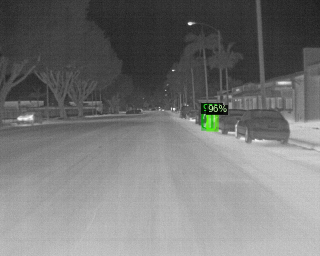

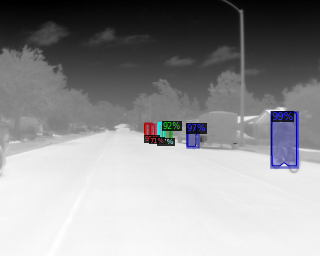

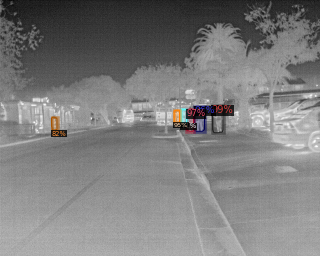

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_thermal_dict(dataset_dir, "test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# **Evaluation the fine-tuned Model**

Evaluation on custom evaluator

In [ ]:
evaluator = CustomEvaluator()
val_loader = build_detection_test_loader(cfg, "FLIR_test")
val_annotation = DatasetCatalog.get("FLIR_test")


def get_all_inputs_outputs(model, annotations, data_loader):
  model.eval()
  for annotation, data in zip(annotations, data_loader):
    yield data, annotations, model(data)

evaluator.reset()
for inputs, annotation, outputs in get_all_inputs_outputs(trainer.model, val_annotation, val_loader):
  evaluator.process(inputs, annotation, outputs, iou_threshold=0.7)
eval_results = evaluator.evaluate()

Evaluation on COCO default evaluator

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("FLIR_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "FLIR_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[11/04 03:19:12 d2.data.common]: Serializing 8861 elements to byte tensors and concatenating them all ...
[11/04 03:19:12 d2.data.common]: Serialized dataset takes 2.94 MiB
[11/04 03:19:12 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/04 03:19:12 d2.evaluation.evaluator]: Start inference on 8861 images
[11/04 03:19:13 d2.evaluation.evaluator]: Inference done 11/8861. 0.0447 s / img. ETA=0:07:15
[11/04 03:19:18 d2.evaluation.evaluator]: Inference done 114/8861. 0.0429 s / img. ETA=0:07:06
[11/04 03:19:23 d2.evaluation.evaluator]: Inference done 221/8861. 0.0426 s / img. ETA=0:06:53
[11/04 03:19:28 d2.evaluation.evaluator]: Inference done 323/8861. 0.0426 s / img. ETA=0:06:52
[11/04 03:19:33 d2.evaluation.evaluator]: Inference done 421/8861. 0.0425 s / img. ETA=0:06:54
[11/04 03:19:38 d2.evaluation.evaluator]: Inference done 524/8861. 0.0424 s / img. ETA=0:06:48
[11/04 03:19:43 d2.eval